# Init

In [1]:
import lovely_tensors as lt
lt.monkey_patch()

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.permute(1,0,2)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [3]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [4]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [5]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params} type {type(model)}")
    return total_params

In [6]:
def get_cameraman_tensor(sidelength):
    pil_img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(pil_img)
    return img, pil_img

In [7]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img, pil_img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.pil_img = pil_img

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [8]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
def mse_and_psnr(im_a, im_b, data_range=1): 
    data_range = 2.
    mse = F.mse_loss(im_a, im_b)
    psnr = 10 * torch.log10((data_range ** 2) / mse)
    return mse, psnr

In [10]:
def pil2tensor(pil): return torch.tensor(
    np.asarray(pil).astype(np.float32)/255).permute(2, 0, 1)

In [11]:
img_pil = Image.open('../../data/Female012_Colour_8k.jpg')
img = pil2tensor(img_pil)

In [12]:
img.shape

torch.Size([3, 8192, 8192])

In [13]:
device = 'cuda:1'

In [14]:
coords = get_mgrid(8192).to(device)
coords

/opt/conda/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor[67108864, 2] n=134217728 x∈[-1.000, 1.000] μ=-7.451e-09 σ=0.577 cuda:1

In [15]:
coords2d = coords.reshape(8192,8192,2)
coords2d

tensor[8192, 8192, 2] n=134217728 x∈[-1.000, 1.000] μ=-7.451e-09 σ=0.577 cuda:1

In [16]:
img.shape

torch.Size([3, 8192, 8192])

In [17]:
img = img.to(device)

pixels = img.reshape(3, -1).permute(1,0)
pixels = (pixels - 0.5) * 2.
pixels

tensor[67108864, 3] n=201326592 x∈[-1.000, 0.835] μ=0.024 σ=0.454 cuda:1

In [18]:
def tensor2pil(t):
    return Image.fromarray( (t.detach().permute(1,2,0).clip(0,1).cpu().numpy()*255).astype(np.uint8) )

size = 256
patch_coords = [
    (size, 0.25, 0.25),
    (size, 0.52, 0.52),
    (size, 0.52, 0.31),
]


def get_patch_uvs(H=4096,W=4096,device='cpu'):
    result = []
    for patch_size, x, y in patch_coords: 
        x = int( x * W )
        y = int( y * H )
        xs = torch.linspace(x, x+patch_size, patch_size).to(device)
        ys = torch.linspace(y, y+patch_size, patch_size).to(device)

        x, y = torch.meshgrid(xs, ys, indexing='xy')
        uvs = torch.stack([x,y], dim=-1)

        result.append(uvs)
        
    return torch.stack(result)


def crop_vis_patches(tex):
    """
    Create patches of 3 textures for visualization
    
    Parameters:
    -- tex_of_0_idt (torch.Tensor): texture of shape [9, H, W] of identity 0 (dataset.textures[0]/255)
    
    Returns:
    -- torch.Tensor: output image of shape [3, 384, 384]
    """
    H,W = tex.shape[:2]
    patches = []

    for patch_size, x, y in patch_coords: 
        x = int( x * W )
        y = int( y * H )

        patch = tex[y:y+patch_size, x:x+patch_size].clone()

        # patch = torch.cat(patch.chunk(3), dim=1)
        patches.append(patch)

    patches = torch.cat(patches, dim=1)
    return patches


In [19]:
coords2d

tensor[8192, 8192, 2] n=134217728 x∈[-1.000, 1.000] μ=-7.451e-09 σ=0.577 cuda:1

In [20]:
coords.shape

torch.Size([67108864, 2])

In [21]:
test_input_2d = crop_vis_patches(coords2d)
test_input_2d_shape = test_input_2d.shape[:2]
test_input_2d_shape

torch.Size([256, 768])

In [22]:
test_input = test_input_2d.reshape(-1, 2)
test_input

tensor[196608, 2] n=393216 x∈[-0.500, 0.102] μ=-0.179 σ=0.254 cuda:1

In [23]:
test_output = F.grid_sample(img[None], crop_vis_patches(coords2d)[None], align_corners=False).squeeze().to(device)
test_output = test_output.reshape(3, -1).permute(1,0)
test_output.shape

torch.Size([196608, 3])

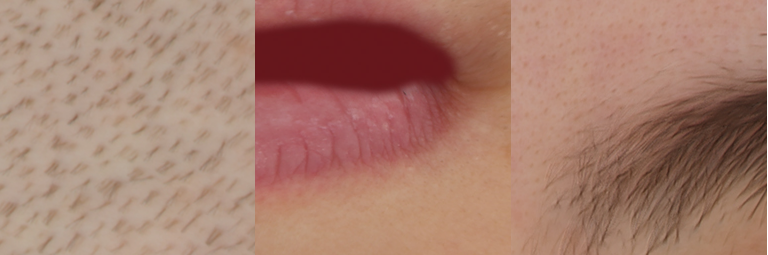

In [24]:
(test_output.reshape(*test_input_2d_shape, 3).permute(2,0,1).rgb)

In [25]:
def to01(t):
    t = t - t.min()
    t = t / t.max()
    return t

In [26]:
cfg = {}
cfg['device'] = device
cfg['lr'] = 1e-4

cfg['total_steps'] = 25_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber-sr-implicit'
cfg['experiment_name'] = 'siren_baseline'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 3,
    'hidden_features': 256,
    'hidden_layers': 8,
    'outermost_linear': True,
}


seed_all(cfg.get('seed', 0))
model = Siren(**cfg['model_kwargs'])
model = model.to(device)

In [27]:
device = cfg['device']
model.to(device)

losses = []

total_steps = cfg['total_steps']
steps_til_summary = cfg['steps_til_summary']

if cfg.get('use_wandb'):
    import wandb
    wandb.init(project=cfg['project'], name=cfg['experiment_name'], config=cfg)

total_params = count_parameters(model)

if cfg.get('use_wandb'):
    wandb.log({'total_params': total_params})

optim = torch.optim.Adam(lr=cfg['lr'], params=model.parameters())

model_input, ground_truth = coords, pixels

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |    512     |
|  net.0.linear.bias  |    256     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    256     |
| net.2.linear.weight |   65536    |
|  net.2.linear.bias  |    256     |
| net.3.linear.weight |   65536    |
|  net.3.linear.bias  |    256     |
| net.4.linear.weight |   65536    |
|  net.4.linear.bias  |    256     |
| net.5.linear.weight |   65536    |
|  net.5.linear.bias  |    256     |
| net.6.linear.weight |   65536    |
|  net.6.linear.bias  |    256     |
| net.7.linear.weight |   65536    |
|  net.7.linear.bias  |    256     |
| net.8.linear.weight |   65536    |
|  net.8.linear.bias  |    256     |
|     net.9.weight    |    768     |
|      net.9.bias     |     3      |
+---------------------+------------+
Total Trainable Params: 527875 type <class '__main__.Siren'>


In [28]:
! nvidia-smi

Thu Mar 16 19:39:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    61W / 300W |   1098MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [29]:
def tensor2pil(t):
    return Image.fromarray( (t.detach().permute(1,2,0).clip(0,1).cpu().numpy()*255).astype(np.uint8) )

def pil2tensor(pil): return torch.tensor(
    np.asarray(pil).astype(np.float32)/255).permute(2, 0, 1)


def imagify_tensor(t): 
    return to01(t).cpu().view(256,256).detach()

In [30]:
batch_size = 512*512
batch_size

262144

In [31]:
pixels

tensor[67108864, 3] n=201326592 x∈[-1.000, 0.835] μ=0.024 σ=0.454 cuda:1

In [32]:
idx = torch.randint(0, len(pixels), (batch_size,))
model_input = coords[idx]
ground_truth = pixels[idx]

model_output, _ = model(model_input)

Step 0, Total loss 0.236833


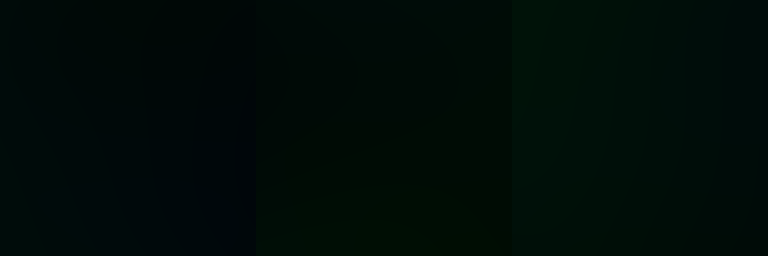

Step 1000, Total loss 0.001772


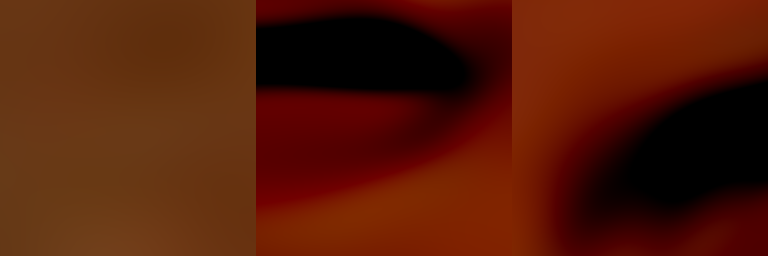

Step 2000, Total loss 0.001471


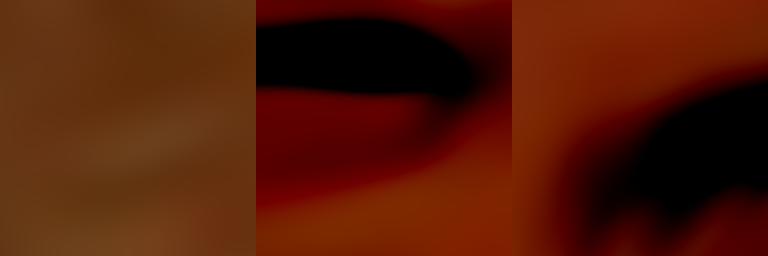

Step 3000, Total loss 0.001570


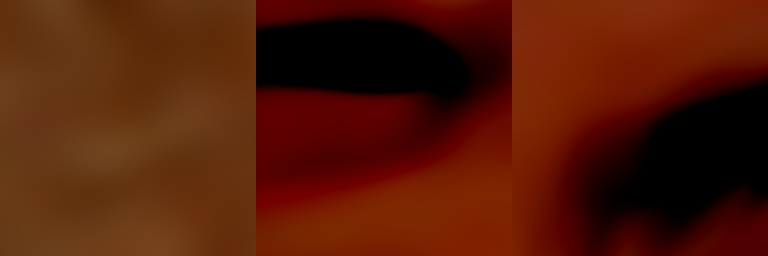

Step 4000, Total loss 0.001456


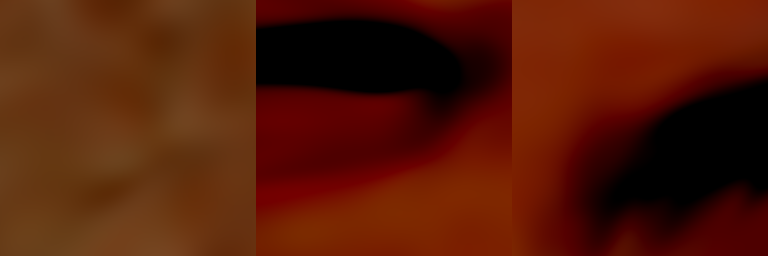

Step 5000, Total loss 0.001413


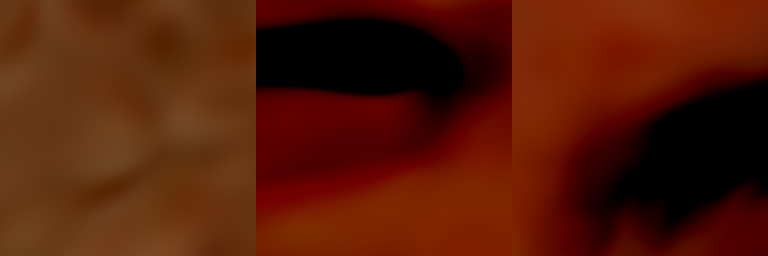

Step 6000, Total loss 0.001368


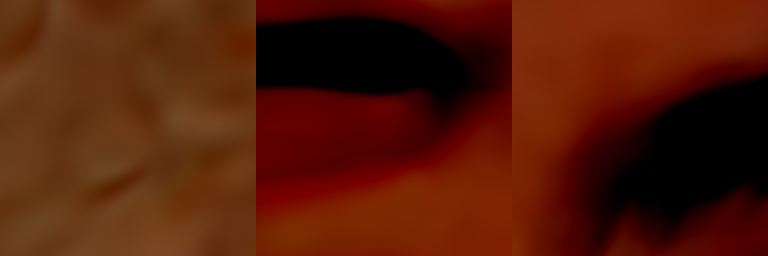

Step 7000, Total loss 0.001438


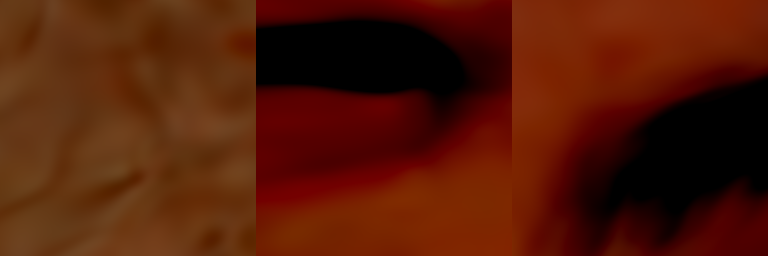

Step 8000, Total loss 0.001983


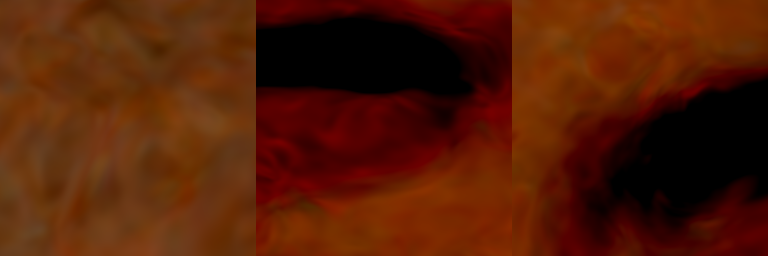

Step 9000, Total loss 0.001365


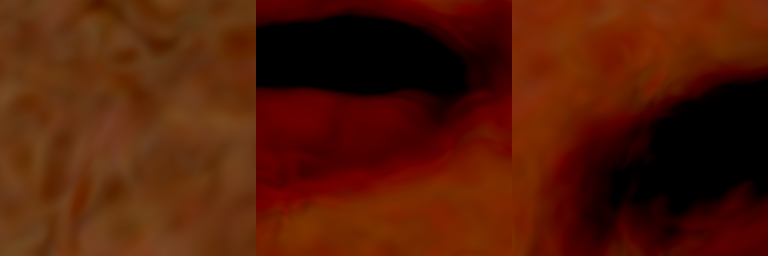

Step 10000, Total loss 0.001260


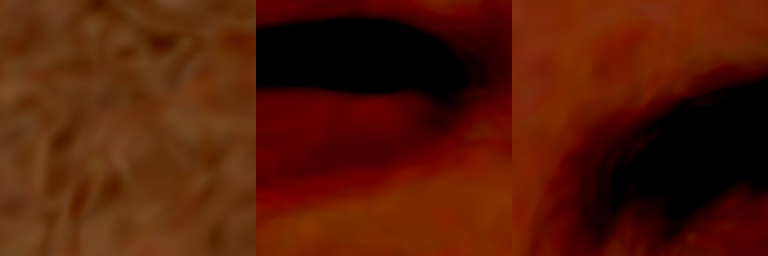

In [ ]:
for step in range(total_steps):
    idx = torch.randint(0, len(pixels), (batch_size,))
    model_input = coords[idx]
    ground_truth = pixels[idx]

    model_output, _ = model(model_input)
    mse, psnr = mse_and_psnr(model_output, ground_truth)
    loss = mse

    if cfg.get('use_wandb'):
        wandb.log({'step': step, 'mse': mse.item(), 'psnr': psnr.item()})

    if not step % steps_til_summary:
        print(f"Step {step}, Total loss {loss:0.6f}")
        model_input, ground_truth = test_input, test_output 
    
        with torch.no_grad():
            model_output, _ = model(model_input)
        # img_grad_tensor = gradient(model_output, coords)
        # img_laplacian_tensor = laplace(model_output, coords)

        img = (model_output.detach().reshape(*test_input_2d_shape, 3).permute(2,0,1)[None]).squeeze()
        img = tensor2pil(img)
        
        # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
        # img_laplacian = imagify_tensor(img_laplacian_tensor)

        # colage = tensor2pil(torch.cat([img, img_grad, img_laplacian], dim=1))
        colage = img
        display(img)

        if cfg.get('use_wandb'):
            wandb.log({'step': step, 'image': wandb.Image(colage)})

    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

In [ ]:
break

# Train pipeline

In [ ]:
def train(model, cfg):
    device = cfg['device']
    model.to(device)
    
    losses = []

    total_steps = cfg['total_steps']
    steps_til_summary = cfg['steps_til_summary']

    if cfg.get('use_wandb'):
        import wandb
        wandb.init(project=cfg['project'], name=cfg['experiment_name'], config=cfg)
        
    total_params = count_parameters(model)

    if cfg.get('use_wandb'):
        wandb.log({'total_params': total_params})

    optim = torch.optim.Adam(lr=cfg['lr'], params=model.parameters())

    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)

    for step in range(total_steps):
        model_output, coords = model(model_input)
        mse, psnr = mse_and_psnr(model_output, ground_truth)
        loss = mse

        if cfg.get('use_wandb'):
            wandb.log({'step': step, 'mse': mse.item(), 'psnr': psnr.item()})

        if not step % steps_til_summary:
            print(f"Step {step}, Total loss {loss:0.6f}")
            img_grad_tensor = gradient(model_output, coords)
            img_laplacian_tensor = laplace(model_output, coords)

            img = imagify_tensor(model_output)
            img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
            img_laplacian = imagify_tensor(img_laplacian_tensor)

            colage = tensor2pil(torch.cat([img, img_grad, img_laplacian], dim=1))
            plt.imshow(colage)
            plt.show()

            if cfg.get('use_wandb'):
                wandb.log({'step': step, 'image': wandb.Image(colage)})

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    wandb.finish()

In [ ]:
class UberLayer(nn.Module):
    def __init__(self, input_dim, h=32):
        super().__init__()
        self.linear = nn.Linear(input_dim, h*4)
        self.h = h
        
    def forward(self, x):
        h = self.h
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * o[..., 2*h:3*h].sin() * o[..., 3*h:4*h].cos()
        return o


class UberNet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        self.net += [UberLayer(in_features, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords
    
    
# ! pip install random-fourier-features-pytorch
import rff
class UberNetWithEncoding(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, encoded_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        self.net += [UberLayer(encoded_size*2, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
        
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        i = self.encoding(coords)
        output = self.net(i)
        return output, coords    

In [ ]:
break

# SIREN

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4

cfg['total_steps'] = 500
cfg['steps_til_summary'] = 100
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'siren_baseline'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 256,
    'hidden_layers': 3,
    'outermost_linear': True,
}


seed_all(cfg.get('seed', 0))
model = Siren(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'siren_baseline'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 256,
    'hidden_layers': 3,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = Siren(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        # self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'siren_no_init'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 256,
    'hidden_layers': 3,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = Siren(**cfg['model_kwargs'])
train(model, cfg)

# uber inr

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_baseline'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 32,
    'hidden_layers': 6,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNet(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:


# X = torch.randn((256, 256, 2))


In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 32,
    'hidden_layers': 6,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 64,
    'hidden_layers': 3,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc_micro'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 64,
    'hidden_layers': 1,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc_micro_128'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 128,
    'hidden_layers': 1,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
count_parameters(model)
breakk()
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc_2_layers'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 128,
    'hidden_layers': 0,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
count_parameters(model)
breakk()
train(model, cfg)

In [ ]:
import torch
import torch.nn as nn

def print_model_shape(model, input_shape):
    with torch.no_grad():
        model.eval()
        x = torch.rand(input_shape)
        print(f"{'Layer Name':<30} {'Input Shape':<20} {'Output Shape':<20}")
        print("-" * 70)
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                x = layer(x)
                print(f"{name:<30} {str(x.shape):<20} {str(x.shape):<20}")

# Example usage
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
)

print_model_shape(model, (1, 3, 32, 32))